# FACIAL KEYPOINTS DETECTION

### PART 1 - Preprocessing and evaluation of the Dataset

#### EDA and Feature Engineering
This is the data analaysis of our dataset whilist removing the missing values and how our input values will look like.

In [1]:
!pip install transformers
!!pip install pytorch_pretrained_vit

['Collecting pytorch_pretrained_vit',
 '  Downloading pytorch-pretrained-vit-0.0.7.tar.gz (13 kB)',
 '  Preparing metadata (setup.py): started',
 "  Preparing metadata (setup.py): finished with status 'done'",
 'Requirement already satisfied: torch in /opt/conda/lib/python3.7/site-packages (from pytorch_pretrained_vit) (1.11.0)',
 'Requirement already satisfied: typing-extensions in /opt/conda/lib/python3.7/site-packages (from torch->pytorch_pretrained_vit) (4.1.1)',
 'Building wheels for collected packages: pytorch_pretrained_vit',
 '  Building wheel for pytorch_pretrained_vit (setup.py): started',
 "  Building wheel for pytorch_pretrained_vit (setup.py): finished with status 'done'",
 '  Created wheel for pytorch_pretrained_vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11132 sha256=41030809abab1df14c00ff9eff53abc2da8e28b2562e5630954f018018a5eee0',
 '  Stored in directory: /root/.cache/pip/wheels/87/1d/d1/c6852ef6d18565e5aee866432ab40c6ffbd3411d592035cddb',
 'Succes

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from IPython.display import clear_output
from time import sleep
import math
import os
import seaborn as sns
from fastai.basics           import *
from fastai.vision.all       import *
from fastai.medical.imaging  import *
from fastai.callback.tracker import *
from fastai.callback.all     import *
import torch
import torchvision
from torch import Tensor,nn, optim
import torch.nn.functional as F
from torch.utils.data import Subset,Dataset, DataLoader,TensorDataset
from torchvision import transforms, utils

**load the data**

In [4]:
train_data = pd.read_csv('../input/facial-keypoints-detection/training.zip', compression='zip', header=0, sep=',', quotechar='"')
test_data = pd.read_csv('../input/facial-keypoints-detection/test.zip', compression='zip', header=0, sep=',', quotechar='"')
lookid_data = pd.read_csv('../input/facial-keypoints-detection/IdLookupTable.csv',header=0, sep=',', quotechar='"')
sample = pd.read_csv('../input/facial-keypoints-detection/SampleSubmission.csv', index_col='RowId')
sample['Location'] = sample['Location'].astype(np.float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [5]:
train_data.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 14...


**visulize the data**

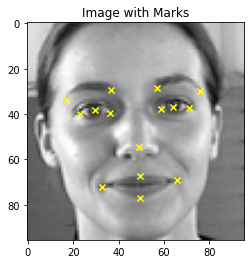

In [6]:
def plot_face(img,marks):
    plt.imshow(img, cmap='gray')
    plt.scatter(marks[0::2], marks[1::2], c='yellow', marker='x')
    plt.title("Image with Marks")
    plt.show()
def visualize_face(i):
    img=np.array(train_data['Image'][i].split(' '),dtype='float').reshape(96,96)
    marks=train_data.drop(['Image'], axis=1).iloc[i].values
    plot_face(img,marks)

visualize_face(9)

**feature engineering**

In [7]:
#feature engineering functions
def df_shape(df):
    return df.shape[0],df.shape[1]
def df_is_null(df):
    is_null_dict={}
    for i in range(0,len(df.columns)):
        a=float(df.isna().sum()[i])
        is_null_dict[df.columns[i]]=a/float(len(df))
    lists = sorted(is_null_dict.items(), key=lambda x: x[1]) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.xticks(rotation=90)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.plot(x, y)
    plt.title("Missing Data Percentage by Column")
    plt.show()
def fill_null(df):
    df.fillna(method = 'ffill',inplace = True)
def corr_heatmap(df):
    sns.heatmap(df.corr(), 
            xticklabels=df.columns.values,
            yticklabels=df.columns.values,cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [8]:
df_shape(train_data)

(7049, 31)

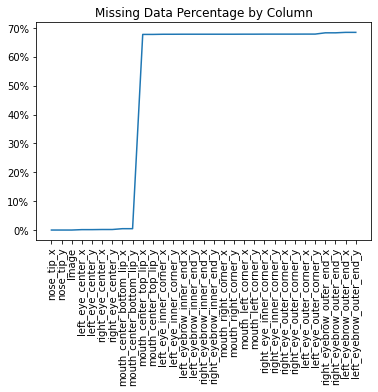

In [9]:
df_is_null(train_data)

In [10]:
fill_null(train_data)

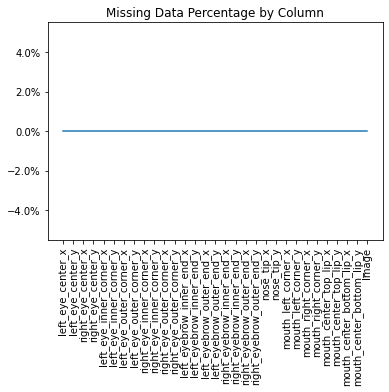

In [11]:
df_is_null(train_data)

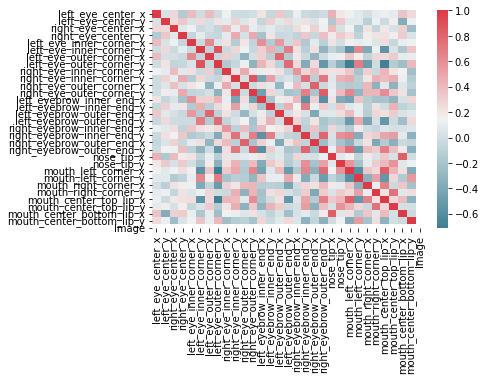

In [12]:
corr_heatmap(train_data)

### PART 2 - Image Augumentation


**Extract training images X and facial marks y**

In [13]:
img = []
for i in range(len(train_data)):
    a=np.array(train_data['Image'][i].split(' '),dtype='float').reshape(96,96)
    img.append(a/255)  
X = np.array(img, dtype='float')

train_data_features = train_data.drop(['Image'], axis=1)
marks = []
for i in range(len(train_data_features)):
  marks.append(train_data_features.iloc[i])  
y = np.array(marks, dtype='float')

**Agumentation functions**

In [14]:
#for a single image, we implement the following augmentation choices: rotation degree, zoom factor, shifting x axis, and shifting y axis
def single_image_augmentation(img, marks, rot_deg, zoom_factor, x_shift_pix, y_shift_pix):
    sz = img.shape[-2:]
    def get_rotation(x):
        mysz = x.new_ones(x.shape[0])
        rot_rad = torch.ones_like(mysz)*(rot_deg / 180.0 * np.pi)
        m11 = rot_rad.cos() / zoom_factor
        m12 = rot_rad.sin() / zoom_factor
        t0 = torch.ones_like(mysz)*(x_shift_pix/48.0)
        t1 = torch.ones_like(mysz)*(y_shift_pix/48.0)
        return affine_mat(m11, m12, t0, -m12, m11, t1)
    t1 = AffineCoordTfm(aff_fs=get_rotation, size=sz)
    p1 = Pipeline(funcs=t1)
    x = TensorImage(img).view([1,1,96,96])
    y = TensorPoint(marks, img_size=[96,96]).view([1,15,2])
    x,y = p1((x,y/48.0-1.0))
    y = y.view([15,2])
    coord_ok = (y[:,0] > -1.0) & (y[:,0] < 1.0) & (y[:,1] > -1.0) & (y[:,1] < 1.0)
    coord_ok = torch.stack([coord_ok, coord_ok], dim=1)
    y = y.where(coord_ok, tensor(np.nan))
    y = y*48.0+48.0
    return np.array(x.reshape(96,96)), np.array(y).flatten()

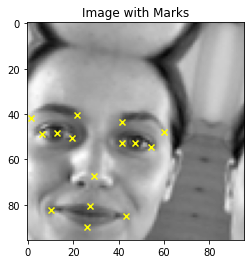

In [15]:
img, marks = single_image_augmentation(X[9], y[9], 10.0, 1.0, 16.0, -16.0)
plot_face(img, marks)

**set the available agumentation choices [rot_deg, zoom_factor, x_shift_pix, y_shift_pix]**

In [16]:
augumentation_choice = []
one_pixel = 2.0/96.0
for dx in range(21):
    for dy in range(21):
        if dx==10 and dy==10:
            continue
        augumentation_choice.append([0.0, 1.0, dx-10.0, dy-10.0])
for rot_deg in range(21):
    if rot_deg==10:
        continue
    augumentation_choice.append([rot_deg-10, 1.0, 0.0, 0.0])
for scale in range(21):
    if scale==10:
        continue
    augumentation_choice.append([0.0, 0.9 + 0.01*scale, 0.0, 0.0])
augumentation_choice[0]

[0.0, 1.0, -10.0, -10.0]

**implement augumentation for all images in training set X,y**

In [17]:
def add_augumented_img_marks(X,y):
    img_list=[]
    marks_list=[]
    for i in range(0,len(X)):
        img,marks = single_image_augmentation(X[i], y[i], *augumentation_choice[i% len(augumentation_choice)])
        if not (np.isnan(img).any()) and not (np.isnan(marks).any()):
            img_list.append(img)
            marks_list.append(marks)
    return img_list,marks_list
img_list,marks_list=add_augumented_img_marks(X,y)

In [18]:
aug_img=np.array(img_list, dtype='float')
aug_marks=np.array(marks_list, dtype='float')

In [19]:
X_aug=np.append(X,aug_img,axis=0)
y_aug=np.append(y,aug_marks,axis=0)

In [20]:
X_aug[0]

array([[0.93333333, 0.9254902 , 0.92941176, ..., 0.98039216, 0.98039216,
        0.98039216],
       [0.92156863, 0.93333333, 0.9254902 , ..., 0.97647059, 0.98039216,
        0.98431373],
       [0.92941176, 0.9254902 , 0.92941176, ..., 0.98431373, 0.98431373,
        0.98039216],
       ...,
       [0.72941176, 0.71764706, 0.70980392, ..., 0.20392157, 0.22352941,
        0.23529412],
       [0.74117647, 0.7372549 , 0.81176471, ..., 0.23921569, 0.27058824,
        0.30588235],
       [0.74901961, 0.72156863, 0.72156863, ..., 0.2745098 , 0.29411765,
        0.35294118]])

### PART 3 - Split the dataset

for models 1&2&3

In [21]:
def train_test_split(features,labels, validation_percentage,batchsize):
    dataset_size = len(features)
    indices = list(range(dataset_size))
    val_num = int(np.floor(validation_percentage*dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[val_num:], indices[:val_num]
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    loader_object = torch.utils.data.TensorDataset(torch.from_numpy(features).float(), torch.from_numpy(labels).float())
    train_loader = torch.utils.data.DataLoader(loader_object, batch_size=batchsize, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(loader_object, batch_size=batchsize, sampler=valid_sampler)
    return train_loader, valid_loader
train_loader, valid_loader=train_test_split(X_aug,y_aug,validation_percentage=0.2,batchsize=32)

for model 4 transformer

In [5]:
transforms_ViT = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
            ])

img = []
for i in range(len(train_data)):
    a=np.array(train_data['Image'][i].split(' '),dtype='float').reshape(96,96)
    img.append(transforms_ViT(torch.from_numpy(a)))  
X = torch.stack(img, dim=0)     
# X = np.array(img, dtype='float')

train_data_features = train_data.drop(['Image'], axis=1)
marks = []
for i in range(len(train_data_features)):
  marks.append(train_data_features.iloc[i])  
y = np.array(marks, dtype='float')

def train_test_split(features,labels, validation_percentage,batchsize):
    dataset_size = len(features)
    indices = list(range(dataset_size))
    val_num = int(np.floor(validation_percentage*dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[val_num:], indices[:val_num]
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    loader_object = torch.utils.data.TensorDataset(features, torch.from_numpy(labels).float())
    train_loader = torch.utils.data.DataLoader(loader_object, batch_size=batchsize, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(loader_object, batch_size=batchsize, sampler=valid_sampler)
    return train_loader, valid_loader
train_loader, valid_loader=train_test_split(X,y,validation_percentage=0.2,batchsize=8)

### PART 4 - Build the models

**Model 1 - Convolutional Neural Network**




parameters:
reference: https://www.youtube.com/watch?v=7ns89gWaY7s

layer size calculation

refernce:https://androidkt.com/calculate-output-size-convolutional-pooling-layers-cnn/

dimension calculation of each cnn layer: output_width = (Width - FilterWidth + 2*Padding)/StrideHorizontal+1

layer 1: (96-5+2*2)/1+1=96  (96)/2=48

layer 2: (48-3+2*2)/1+1=50  (50)/2=25

layer 3: (25-3+2*2)/1+1=26  (26)/2=13

layer 4: (13-2+2*2)/1+1=16   (16)/2=8

In [22]:
class CNNBaseline(nn.Module):
    def __init__(self):
        super(CNNBaseline, self).__init__()

        self.cnn1 = nn.Sequential(
          nn.Conv2d(  in_channels=1, out_channels=4,kernel_size=[5,5], stride=1, padding=2),
          nn.BatchNorm2d(4),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(0.2)
        )
        self.cnn2 = nn.Sequential(
          nn.Conv2d( in_channels=4, out_channels=64, kernel_size=[3,3], stride=1, padding=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(0.2)
        )
        self.cnn3 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[3,3], stride=1, padding=2),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(0.2)
        )
        self.cnn4 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[2,2], stride=1, padding=2),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(0.2)
        )
        
        self.fc1=nn.Sequential(
          nn.Flatten(),
          nn.Linear(256*8*8,1024),
          nn.ReLU(),
          nn.Dropout(0.2)
        )        
        self.fc2=nn.Sequential(
          nn.Linear(1024,256),
          nn.ReLU(),
          nn.Dropout(0.2)
        )
        self.fc3=nn.Sequential(
          nn.Linear(256,30)
        )  

    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

**Model 2 - Restnet18**

In [23]:
from torchvision.models import resnet18

def get_resnet18(pretrained=True,output_dim: int = 30):
  model = torchvision.models.resnet18(pretrained)
  model.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  numFit = model.fc.in_features
  model.fc = nn.Linear(numFit, output_dim)
  return model

**Model 3- Mobilenet_v3**

In [24]:
def get_mobilenet_v3_large(pretrained=True,output_dim: int = 30):
    model = torchvision.models.mobilenet_v3_large(pretrained, progress=True)
    model.features[0][0]=nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[-1] = nn.Linear(1280, output_dim)
    return model

**Model 4 - Transformers - ViTModel**

In [8]:
from pytorch_pretrained_vit import ViT

class vitmodel(nn.Module):
    def __init__(self):
        super(vitmodel, self).__init__()
        self.vit = ViT('B_16_imagenet1k', pretrained=True)
        self.vit.patch_embedding=nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
        self.fclast=nn.Linear(in_features=1000, out_features=30, bias=True)
    def forward(self, x):
        x = self.vit(x)
        x = self.fclast(x)
        return x

### PART 5 - Train, Test and Evaluate

for model 4, change the input size from 96 to 384

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
def testing(model, device, valid_loader,criterion):
  # we have to tell the model that we are on evaluation mode
  model.eval()
  test_loss = 0
  for data, target in valid_loader:
    data, target = data.to(device), target.to(device)
    # Arrange the data dimensions to feed the model
    data = data.view(-1, 96*96)
    data = data.view(-1, 1, 96, 96)
    # Prediction of coordinates for test data
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    
  test_loss /= len(valid_loader.dataset)
  return test_loss

def training(epochs, model, criterion, device, train_loader, valid_loader, optimizer):
  train_error_list = []
  val_error_list = []
  for epoch in range(epochs):
    # We have to tell the model that we are on trainnig mode (not all the parameters are the same in evaluation and training mode)
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
    
      # Arrange the data dimensions to feed the model
        data = data.view(-1, 96*96)
        data = data.view(-1, 1, 96, 96)
        optimizer.zero_grad()
        output = model(data)
        loss =criterion(output, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader.dataset)
    # Send the validation data to testing data to evaluate how good is doing the model
    eval_loss = testing(model, device, valid_loader,criterion=criterion)
    train_error_list.append(train_loss)
    val_error_list.append(eval_loss)
    if (epoch+1) % 10 == 0:
      print("End of epoch {}: \nTraining error = [{}]\tValidation error = [{}]".format(epoch+1, train_loss, eval_loss))
  return train_error_list, val_error_list

def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np
def run_model(model):
    model.to(device)
    criterion = RMSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3)
    print('Number of parameters: {}'.format(get_n_params(model)))
    train_RMSE_list, valid_RMSE_list = training(500, model, criterion, device, train_loader, valid_loader, optimizer)
    return train_RMSE_list, valid_RMSE_list

In [27]:
model1=CNNBaseline()
train_RMSE_list_1,valid_RMSE_list_1=run_model(model1)

Number of parameters: 17256910
End of epoch 10: 
Training error = [0.1237240821598885]	Validation error = [0.022739602155901845]
End of epoch 20: 
Training error = [0.11807409468850237]	Validation error = [0.018436722052584602]
End of epoch 30: 
Training error = [0.1167557463119226]	Validation error = [0.025561002016118706]
End of epoch 40: 
Training error = [0.11242073686012466]	Validation error = [0.01895549915353864]
End of epoch 50: 
Training error = [0.11362434703368944]	Validation error = [0.02119755128790428]
End of epoch 60: 
Training error = [0.11070484109422901]	Validation error = [0.01716112906184071]
End of epoch 70: 
Training error = [0.11019176540433469]	Validation error = [0.0176349481743351]
End of epoch 80: 
Training error = [0.10520615676007655]	Validation error = [0.018421149781236875]
End of epoch 90: 
Training error = [0.10569784280966907]	Validation error = [0.01868571688258594]
End of epoch 100: 
Training error = [0.10432226607176388]	Validation error = [0.028197

In [28]:
pd.DataFrame(train_RMSE_list_1).to_csv('train_RMSE_list_1.csv')
pd.DataFrame(train_RMSE_list_1).to_csv('valid_RMSE_list_1.csv')

In [29]:
model2=get_resnet18(pretrained=True)
train_RMSE_list_2,valid_RMSE_list_2=run_model(model2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Number of parameters: 11185630
End of epoch 10: 
Training error = [0.038844939163670066]	Validation error = [0.013778255018067263]
End of epoch 20: 
Training error = [0.026481451912439665]	Validation error = [0.010578112455793097]
End of epoch 30: 
Training error = [0.021908458877253255]	Validation error = [0.012859161201019364]
End of epoch 40: 
Training error = [0.017130261645114653]	Validation error = [0.010060461412837113]
End of epoch 50: 
Training error = [0.01482666993808521]	Validation error = [0.009990169619838035]
End of epoch 60: 
Training error = [0.013121173883424866]	Validation error = [0.009987294784859671]
End of epoch 70: 
Training error = [0.012450187376433192]	Validation error = [0.009764840560376204]
End of epoch 80: 
Training error = [0.011179403472248814]	Validation error = [0.0097921977439805]
End of epoch 90: 
Training error = [0.010542038840668623]	Validation error = [0.010044478889661678]
End of epoch 100: 
Training error = [0.010007489076603867]	Validation er

In [30]:
pd.DataFrame(train_RMSE_list_2).to_csv('train_RMSE_list_2.csv')
pd.DataFrame(train_RMSE_list_2).to_csv('valid_RMSE_list_2.csv')

In [31]:
model3=get_mobilenet_v3_large(30)
train_RMSE_list_3,valid_RMSE_list_3=run_model(model3)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

Number of parameters: 4240174
End of epoch 10: 
Training error = [0.05311332788214123]	Validation error = [0.014293566916869444]
End of epoch 20: 
Training error = [0.04465493766569752]	Validation error = [0.012608002170699559]
End of epoch 30: 
Training error = [0.04079372075199868]	Validation error = [0.012969820635449665]
End of epoch 40: 
Training error = [0.038798597702292895]	Validation error = [0.010801688927912544]
End of epoch 50: 
Training error = [0.03755022330123341]	Validation error = [0.01038279179402314]
End of epoch 60: 
Training error = [0.03665512697383835]	Validation error = [0.010631161656373896]
End of epoch 70: 
Training error = [0.03412398154259889]	Validation error = [0.00988559205237315]
End of epoch 80: 
Training error = [0.03349886168234759]	Validation error = [0.010306681104511613]
End of epoch 90: 
Training error = [0.03356665970644397]	Validation error = [0.010240159223156315]
End of epoch 100: 
Training error = [0.03191966557436183]	Validation error = [0.

In [32]:
pd.DataFrame(train_RMSE_list_3).to_csv('train_RMSE_list_3.csv')
pd.DataFrame(train_RMSE_list_3).to_csv('valid_RMSE_list_3.csv')

In [ ]:
model4=vitmodel()
train_RMSE_list_4,valid_RMSE_list_4=run_model(model4)

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

Loaded pretrained weights.
Number of parameters: 86496310


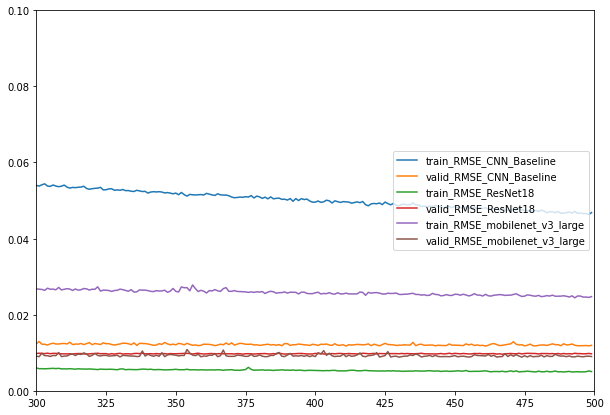

In [76]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(train_RMSE_list_1,label='train_RMSE_CNN_Baseline')
plt.plot(valid_RMSE_list_1,label='valid_RMSE_CNN_Baseline')
plt.plot(train_RMSE_list_2,label='train_RMSE_ResNet18')
plt.plot(valid_RMSE_list_2,label='valid_RMSE_ResNet18')
plt.plot(train_RMSE_list_3,label='train_RMSE_mobilenet_v3_large')
plt.plot(valid_RMSE_list_3,label='valid_RMSE_mobilenet_v3_large')

plt.xlim(300,500)
plt.ylim(0,0.1)
plt.legend(loc=5)

### Visualizing The Outputs

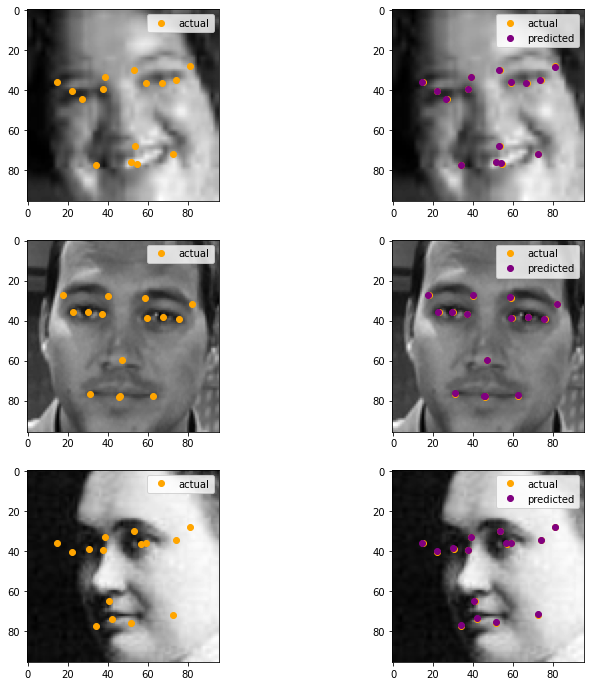

In [50]:
def plot_samples(X, y, model, num_samples):
  fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(12,12))
  
  for row in range(num_samples):
    # get random indexes to dispaly the results on the images
    sample_idx = np.random.choice(len(X))
    x = X[sample_idx]
    x = torch.from_numpy(x).float().view(1,1,96,96).to(device)
    actual_y = y[sample_idx]
    pred_y = model(x)
    img = X[sample_idx].reshape(96,96)
    
    # Set the coordinates data so we can plot them along the original image
    actual_y = np.vstack(np.split(actual_y, 15)).T
    pred_y = pred_y.cpu().data.numpy()[0]
    pred_y = np.vstack(np.split(pred_y, 15)).T
    
    # Representation
    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].plot(actual_y[0], actual_y[1], 'o', color='orange', label='actual')
    axes[row, 0].legend()
    axes[row, 1].imshow(img, cmap='gray')
    axes[row, 1].plot(actual_y[0], actual_y[1], 'o', color='orange', label='actual')
    axes[row, 1].plot(pred_y[0], pred_y[1], 'o', color='purple', label='predicted')
    axes[row, 1].legend()

 # change three for another number to see display the results in more than three pictures 
plot_samples(X, y, model2, 3)

## Reading the Test Dataset

In [51]:
img_test = []

for i in range(len(test_data)):
    a=np.array(test_data['Image'][i].split(' '),dtype='float').reshape(96,96)
    img_test.append(a/255)
test_X = np.array(img_test, dtype='float')

In [79]:
len(test_X)

1783

## Prediction on test set:

In [81]:
# Prepare the data to feed it into the model, numpy to torch plus the size (4dimensions)
test_X_torch = torch.from_numpy(test_X).float().view(len(test_X),1,96,96).to(device)
# Obtaining the coordinates
test_predictions = model3(test_X_torch)
test_predictions = test_predictions.cpu().data.numpy()
# lists of coordinates
keypts_labels = train_data.columns.tolist()

In [82]:
test_X_torch.shape

torch.Size([1783, 1, 96, 96])

In [83]:
len(test_predictions)

1783

Visualizing the test predictions

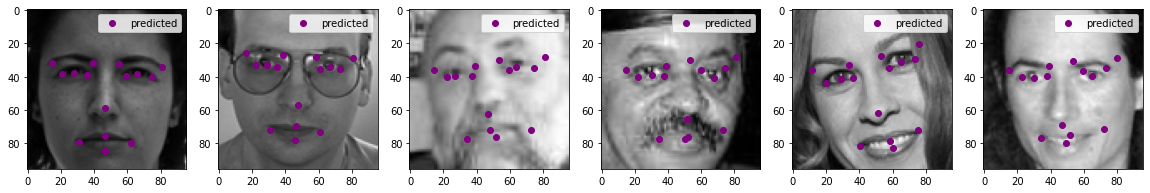

In [93]:
def plot_samples_test(X, y, num_samples):
  fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20,12))
  
  for row in range(num_samples):
    sample_idx = np.random.choice(len(X))
    img = X[sample_idx].reshape(96,96)
    predicted = y[sample_idx]
    
    predicted = np.vstack(np.split(predicted, 15)).T
    axes[row].imshow(img, cmap='gray')
    axes[row].plot(predicted[0], predicted[1], 'o', color='Purple', label='predicted')
    axes[row].legend()
  
plot_samples_test(test_X, test_predictions, 6)

In [91]:
namedict = {train_data.columns[k1]: k1 for k1 in range(len(train_data.columns))}
for k1 in range(sample.shape[0]):
    imageid = lookid_data.iloc[k1]['ImageId']-1
    featurename = lookid_data.iloc[k1]['FeatureName']
    featurecol = namedict[featurename]
    sample.iloc[k1]['Location'] = test_predictions[imageid,featurecol]

**submit to kaggle**

In [92]:
sample.to_csv('submission_mobilenet_v3_large.csv')

**Applying model to random images**

In [210]:
import cv2
img_esteban = cv2.imread("../input/cvcv1cv4/Screenshot 2022-11-01 at 16.11.12.png", cv2.IMREAD_GRAYSCALE)

convert_tensor = transforms.ToTensor()
img_esteban=convert_tensor(img_esteban)
resize_tensor=transforms.Resize([96,96])
img_esteban=resize_tensor(img_esteban)


In [211]:
img_esteban=(img_esteban).view(1, 96*96)
img_esteban=(img_esteban).view(1, 1, 96, 96)

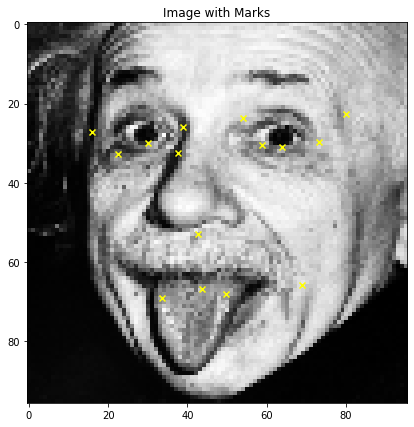

In [212]:
img_esteban=img_esteban.to(device)

marks_esteban=model1(img_esteban)
plot_face(img_esteban.detach().to('cpu').numpy().reshape(96, 96),marks_esteban.detach().to('cpu').numpy().reshape(30))